In [1]:
import numpy as np
import math
import numpy.linalg as nla
import matplotlib.pyplot as plt
from scipy.integrate import solve_bvp, ode, odeint
from scipy.optimize import least_squares
plt.rc('text',usetex=True)
from sympy import lambdify, simplify, Symbol, init_printing, log, solve, Function
init_printing()

In [ ]:
# Material properties:
# mu = 1. 
# kapp = 20.
# alph = 2.5

mu=Symbol('mu')
kapp=Symbol('kappa')
alph = Symbol('alpha')
lam1, lam2, lam3 = Symbol('lambda_1'), Symbol('lambda_2'), Symbol('lambda_3')
lam = Symbol('lambda')
R = Symbol('R')
B = Symbol('B')
f = Function('f', real=True)
fp = Function('f_p', real=True)
Jdet = lam1*lam2*lam3

In [ ]:
# define the stored energy function in terms of the eigen-stretches

W = mu/alph*(lam1**alph + lam2**alph + lam3**alph ) - mu*log(Jdet) + kapp/2*(Jdet - 1)**2

In [ ]:
# compute the symbolic derivatives: 
    # useful in calculation of the eigen stresses
    
dW_dl1 = lambdify((lam1, lam2, lam3), simplify(W.diff(lam1)), 'numpy')
dW_dl2 = lambdify((lam1, lam2, lam3), simplify(W.diff(lam2)), 'numpy')
dW_dl3 = lambdify((lam1, lam2, lam3), simplify(W.diff(lam3)), 'numpy')

# t1 = dW_dl1(R*fp+f, f, f)
# t2 = dW_dl2(R*fp+f, f, f)
# t3 = dW_dl3(R*fp+f, f, f)
t1 = simplify(1./(lam2*lam3)*W.diff(lam1)).subs([(lam1,R*fp(R)+f(R)), (lam2, f(R)), (lam3, f(R))])
t2 = simplify(1./(lam1*lam3)*W.diff(lam2)).subs([(lam1,R*fp(R)+f(R)), (lam2, f(R)), (lam3, f(R))])
t3 = simplify(1./(lam1*lam2)*W.diff(lam3)).subs([(lam1,R*fp(R)+f(R)), (lam2, f(R)), (lam3, f(R))])

In [ ]:
t1_func = lambdify((lam1, lam2, lam3), simplify(1./(lam2*lam3)*W.diff(lam1)), 'numpy')  #takes three arguments (lambda_1, lambda_2, lambda_3)

In [ ]:
# Calculate the second derivative f''(R), which will be helpful later on to impose BC and 
# solve the resulting 1st-order system

fpp = simplify(solve(t1.diff(R)+2./R*(t1-t2),fp(R).diff(R))[0])
fpp = simplify(fpp.subs(f(R).diff(R), fp(R)))
fpp

In [ ]:
p = Symbol('p')
# solve(p + )
t1.subs([(f(R),lam), (alph,2.5)])

In [ ]:
def ode_sys(r, z):
    """
    Let's call the state variable as z = [f, f']
        -- implies z' = [f', f''], where f'' comes from the ode
    """
    mu, kappa, alpha = 1., 20., 2.5
    f_r, fp_r = z
    fpp_r = (-2.0*r**4*kappa*f_r**4*fp_r**4 - 8.0*r**3*kappa*f_r**5*fp_r**3 - 10.0*r**2*kappa*f_r**6*fp_r**2 + 2.0*r**2*mu*(r*fp_r + f_r)**alpha*fp_r**2 - 2.0*r**2*mu*fp_r**2 - 2*r*alpha*mu*(r*fp_r + f_r)**alpha*f_r*fp_r - 4.0*r*kappa*f_r**7*fp_r + 6.0*r*mu*(r*fp_r + f_r)**alpha*f_r*fp_r - 4.0*r*mu*f_r*fp_r - 2.0*r*mu*f_r**(alpha + 1)*fp_r + 2.0*mu*(r*fp_r + f_r)**alpha*f_r**2 - 2.0*mu*f_r**(alpha + 2))/(r**2*(r**2*kappa*f_r**4*fp_r**2 + 2.0*r*kappa*f_r**5*fp_r + alpha*mu*(r*fp_r + f_r)**alpha + kappa*f_r**6 - mu*(r*fp_r + f_r)**alpha + mu)*f_r)
    return [fp_r, fpp_r]

In [ ]:
def bc_z(za, zb):
    mu, kappa, alpha = 1., 20., 2.5
    A = 0.95
    B = 1.
    f_A, fp_A = za
    f_B, fp_B = zb
    
#     include the boundary condition in terms of the cauchy pressure
    bc_inside = p + t1_func(A*fp_A + f_A, f_A, f_A)
    bc_outside = t1_func(B*fp_B + f_B, f_B, f_B)
    return [bc_inside, bc_outside]

In [ ]:
A = 0.95
B = 1.
pvals = np.linspace(0,0.09*10**6,100)
rVals = np.linspace(A,B,1000)
z_a = np.ones((2, rVals.size))
z_a[1] = 2.
rB = np.zeros(pvals.shape)
rVals_plot = np.linspace(A,B,10**4)


In [ ]:
for idx, p in enumerate(pvals):
    z_a = np.ones((2, rVals.size))*(1+p**(1./4))
    z_a[1] = 1./(1+p**(1./4))
    res_a = solve_bvp(ode_sys,bc_z, rVals, z_a,tol=1.e-8, max_nodes = 1.e8,verbose=1)
    rB[idx] = res_a.sol(rVals_plot)[0][-1]

In [ ]:
np.linspace(0,1,11)

In [ ]:
90000**(0.25)

In [2]:
R = Symbol('R')
A = Symbol('A')
lam_z = Symbol('lambda_z')
f = Function('f')

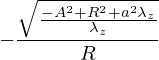

In [8]:
LHS = (1-lam_z*f(R)**2)/(1-lam_z*f(A)**2)
RHS = A**2/R**2
simplify(solve(simplify(LHS-RHS),f(R))[0]).subs(f(A)*A,Symbol('a'))